# Advanced Regression

In this notebook, seven regression models will be created to examine which model performs best in predicting home sale prices in Ames, IA. The data has already been wrangled in a previous notebook, which included imputing null values in the features,  encoding the categorical variables, scaling all of the features, and taking the log of the target variable.

The models include five variations of linear regression and two ensemble methods.

In [1]:
# import packages that will be used for plotting and analyzing the data

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from scipy import stats
%matplotlib inline

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

from sklearn.dummy import DummyClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, RobustScaler


In [2]:
# read in data file for training the ML models into a DataFrame

df = pd.read_csv('Data/train_imputed.csv')

In [3]:
# set the feature and target variables for the 

X = df.drop('SalePrice', axis=1)
y = df.SalePrice

In [4]:
X.head()

,MSSubClass,LotFrontage,LotArea,LotShape,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.2,-0.265787,-0.254076,0.0,0.0,0.5,0.0,0.652174,0.243243,1.193303,...,0,0,0,1,0,0,0,0,1,0
1,-0.6,0.523686,0.030015,0.0,0.0,0.0,3.0,0.065217,-0.486486,0.000000,...,0,0,0,1,0,0,0,0,1,0
2,0.2,-0.107893,0.437624,-1.0,0.0,0.5,0.0,0.608696,0.216216,0.986301,...,0,0,0,1,0,0,0,0,1,0
3,0.4,-0.528945,0.017663,-1.0,0.0,0.5,0.0,-1.260870,-0.648649,0.000000,...,0,0,0,1,1,0,0,0,0,0
4,0.2,0.734213,1.181201,-1.0,0.0,1.0,0.0,0.586957,0.162162,2.130898,...,0,0,0,1,0,0,0,0,1,0


The Kaggle competition will be scored based on the Root Mean Squared Logarithmic Error (rmsle), so the models will be optimized for this value. However, the Root Mean Squared Error will still be computed for every model. 

The following functions will be used to compute the RMSLE and RMSE.

In [5]:
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Linear Regression with PCA

This first model will use principal component analysis (PCA) to generate new components for to be used as features in a linear regression. As a PCA generates new features, multicollinearity will not be a concern. Therefore, the PCA will be run with all of the available features in the dataset.

First, the PCA will be run and the number of features plotted against their explained variance values to determine a suitable number of components to fit to the PCA.

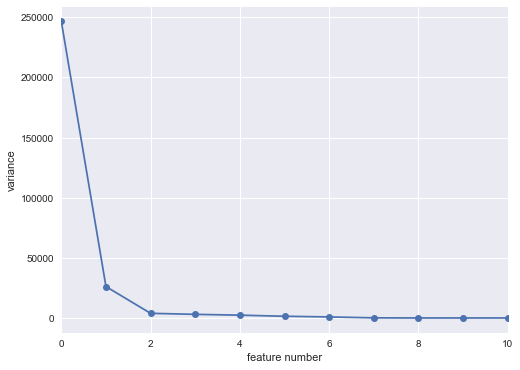

In [7]:
# create PCA object and plot explained variance values against the number of components.
pca = PCA()
pca.fit(X)
features = range(pca.n_components_)

sns.set()
plt.figure(figsize=(8, 6))
sns.set()
plt.plot(features, pca.explained_variance_, '-o')
plt.xlabel('feature number')
plt.ylabel('variance')
plt.xlim(0, 10)
plt.show()

An elbow point can be observed at 2 components, so the PCA will be created with 2 components and fit to the features from the dataset. 

In [8]:
# run PCA with 2 components and store them in a DataFrame

model=PCA(n_components=2)
model.fit(X)
df_components = pd.DataFrame(model.transform(X))
df_components.columns = ['component1', 'component2']

In [9]:
# join the new PCA components with the target variable and split into training and test sets.

df_PCA = df_components.join(y, how='left')

X_train, X_test, y_train, y_test = train_test_split(df_components, y, test_size=0.3, random_state=10)

In [10]:
# fit a linear regression to the principal components

reg_PCA = LinearRegression()
reg_PCA.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
# tune hyperparameters

param_grid = {'fit_intercept':[True, False], 'normalize':[True, False]}

reg_PCA_cv = GridSearchCV(reg_PCA, param_grid, cv=5)
reg_PCA_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
print("Tuned Regression Parameter: {}".format(reg_PCA_cv.best_params_))

Tuned Regression Parameter: {'fit_intercept': True, 'normalize': True}


In [13]:
# refit model with best hyperparameters. In this case, the features should be normalized.

reg_PCA = LinearRegression(fit_intercept=True, normalize=True)
reg_PCA.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [14]:
# predict home prices using the model and compute RMSLE value

y_pred_PCA = reg_PCA.predict(X_test)

pca_rmsle = rmsle(y_test, y_pred_PCA)
print('PCA Score:', pca_rmsle)

PCA Score: 0.0308688843712


In [15]:
# compute RMSE value

rmse(y_test, y_pred_PCA)

0.40117887629488891

# Linear Regression (out of box)

This next model will examine how well an out of box regression performs without any feature selection.

In [16]:
# split the entire dataset into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [17]:
# fit a linear regression model

reg_oob = LinearRegression()
reg_oob.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [18]:
# predict home prices using the model and compute RMSLE value

y_pred_reg_oob = reg_oob.predict(X_test)

reg_rmsle = rmsle(y_test, y_pred_reg_oob)
print('LinReg Score: ', reg_rmsle)

LinReg Score:  0.00931802206761


In [19]:
# compute RMSE value

rmse(y_test, y_pred_reg_oob)

0.11960540981745206

This model seems to perform better than the regression fit with principal components, but performance may be boosted even further with different methods.

# Linear Regression with VIF

As there was a significant amount of multicollinearity noted during the statistical analysis portion of this project and linear regression models are susceptible to multicollinearity in their features, this next model will examine the model's performance after models with high variance inflation factors are dropped.

First, a ReduceVIF class will be created which can calculate VIF values and drop any features with a VIF over the threshold of 5.

In [20]:
# from https://www.kaggle.com/ffisegydd/sklearn-multicollinearity-class/code

class ReduceVIF(BaseEstimator, TransformerMixin):
    def __init__(self, thresh=5.0):
        
        # the threshold will be set to 5. 
        self.thresh = thresh

    def fit(self, X, y=None):
        print('ReduceVIF fit')
        if hasattr(self, 'imputer'):
            self.imputer.fit(X)
        return self

    def transform(self, X, y=None):
        print('ReduceVIF transform')
        columns = X.columns.tolist()
        if hasattr(self, 'imputer'):
            X = pd.DataFrame(self.imputer.transform(X), columns=columns)
        return ReduceVIF.calculate_vif(X, self.thresh)

    @staticmethod
    def calculate_vif(X, thresh=5.0):
        # Taken from https://stats.stackexchange.com/a/253620/53565 and modified
        dropped=True
        while dropped:
            variables = X.columns
            dropped = False
            vif = [variance_inflation_factor(X[variables].values, X.columns.get_loc(var)) for var in X.columns]
            
            max_vif = max(vif)
            if max_vif > thresh:
                maxloc = vif.index(max_vif)
                print(f'Dropping {X.columns[maxloc]} with vif={max_vif}')
                X = X.drop([X.columns.tolist()[maxloc]], axis=1)
                dropped=True
        return X

In [21]:
# a ReduceVIF object is create and fit_transformed to the data

transformer = ReduceVIF()
X = transformer.fit_transform(X, y)

ReduceVIF fit
ReduceVIF transform


C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\stats\outliers_influence.py:167: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\regression\linear_model.py:1386: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


Dropping BsmtFinSF1 with vif=inf
Dropping 1stFlrSF with vif=inf
Dropping MSZoning_C (all) with vif=inf
Dropping Street_Grvl with vif=inf
Dropping Alley_Grvl with vif=inf
Dropping LandContour_Bnk with vif=inf
Dropping Utilities_AllPub with vif=inf
Dropping LotConfig_Corner with vif=inf
Dropping Neighborhood_Blmngtn with vif=inf
Dropping Condition1_Artery with vif=inf
Dropping Condition2_Artery with vif=inf
Dropping BldgType_1Fam with vif=inf
Dropping HouseStyle_1.5Fin with vif=inf
Dropping RoofStyle_Flat with vif=inf
Dropping RoofMatl_CompShg with vif=inf
Dropping Exterior1st_AsbShng with vif=inf
Dropping Exterior1st_CBlock with vif=inf
Dropping Exterior2nd_AsbShng with vif=inf
Dropping MasVnrType_BrkCmn with vif=inf
Dropping Foundation_BrkTil with vif=inf
Dropping Heating_Floor with vif=inf
Dropping Electrical_FuseA with vif=inf
Dropping GarageType_2Types with vif=inf
Dropping Fence_GdPrv with vif=inf
Dropping MiscFeature_Gar2 with vif=inf
Dropping SaleType_COD with vif=inf
Dropping Sa

C:\Users\wongk3.NA\AppData\Local\Continuum\Anaconda2\envs\newPy36\lib\site-packages\statsmodels\regression\linear_model.py:1388: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.uncentered_tss


Dropping MiscFeature_None with vif=4365.1712836591305
Dropping GarageYrBlt with vif=2232.9888815104828
Dropping Heating_GasA with vif=1080.536772688213
Dropping Condition2_Norm with vif=721.6011720244313
Dropping RoofStyle_Gable with vif=439.2597024224827
Dropping Street_Pave with vif=318.84317717626016
Dropping Exterior1st_VinylSd with vif=170.8732506889865
Dropping MSZoning_RL with vif=158.58315459641068
Dropping GarageType_Attchd with vif=126.08657720027163
Dropping MasVnrType_None with vif=62.151741101657336
Dropping SaleType_New with vif=52.04978235758153
Dropping Exterior2nd_MetalSd with vif=50.22142901263269
Dropping Alley_None with vif=42.40460934677041
Dropping 2ndFlrSF with vif=36.69069788633362
Dropping SaleType_WD with vif=34.43328323256324
Dropping Condition1_Norm with vif=34.1655100518604
Dropping MSSubClass with vif=32.8237883342591
Dropping LandContour_Lvl with vif=29.079481465828596
Dropping Exterior2nd_CmentBd with vif=27.25478552644733
Dropping Fence_None with vif=25

In [22]:
# after dropping values with high VIFs, the DataFrame has 162 remaining features.

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Columns: 162 entries, LotFrontage to SaleCondition_Partial
dtypes: float64(40), int64(122)
memory usage: 1.8 MB


In [23]:
# the new DataFrame is split intro training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)


In [24]:
# fit a linear regression model to the training data

reg_VIF = LinearRegression()
reg_VIF.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [25]:
# predict home prices using the model and compute RMSLE value

y_pred_reg_VIF = reg_VIF.predict(X_test)

regvif_rmsle = rmsle(y_test, y_pred_reg_VIF)
print('LinReg VIF Score: ', regvif_rmsle)

LinReg VIF Score:  0.0109494094158


In [26]:
# tune hyperparameters

reg_cv = GridSearchCV(reg_VIF, param_grid, cv=5)
reg_cv.fit(X_train,y_train)

print("Tuned Regression (with VIF) Parameter: {}".format(reg_cv.best_params_))

Tuned Regression (with VIF) Parameter: {'fit_intercept': True, 'normalize': False}


As the best parameters seem to be the default ones, we will simply proceed with scoring this model. The RMSLE value has already been computed.

In [27]:
# compute RMSE value

rmse(y_test, y_pred_reg_VIF)

0.14075436319066861

Although the linear regression model fit after dropping high-VIF features performs slightly worse than the out-of-box linear regression if optimizing for RMSLE, this model has significantly lower complexity.

# Ridge Regression

This next model will use ridge regression, which uses L2 regularization.

In [28]:
# create a ridge regressor and fit the training data to it

reg_ridge = Ridge()
reg_ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [29]:
# predict home prices using the model and compute RMSLE value

y_pred_reg_ridge = reg_ridge.predict(X_test)

rmsle(y_test, y_pred_reg_ridge)

0.010504736344298448

In [30]:
# tune hyperparameters

param_grid = {'alpha': [0.01, 0.1, 1.0, 10, 100], 
             'fit_intercept': [True, False], 
             'normalize': [True, False]}

reg_ridge_cv = GridSearchCV(reg_ridge, param_grid, cv=5)
reg_ridge_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.01, 0.1, 1.0, 10, 100], 'fit_intercept': [True, False], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [31]:
print("Tuned Ridge Regression Parameter: {}".format(reg_ridge_cv.best_params_))

Tuned Ridge Regression Parameter: {'alpha': 10, 'fit_intercept': True, 'normalize': False}


In [32]:
# refit the ridge regressor with tuned hyperparameters

reg_ridge = Ridge(alpha=10, fit_intercept=True, normalize=False)
reg_ridge.fit(X_train, y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [33]:
# predict home prices using the model and compute RMSLE value

y_pred_reg_ridge = reg_ridge.predict(X_test)

ridge_rmsle = rmsle(y_test, y_pred_reg_ridge)
print("Ridge Score: ", ridge_rmsle)

Ridge Score:  0.0102363636569


In [34]:
# compute RMSE value

rmse(y_test, y_pred_reg_ridge)

0.13177705575992346

In this case, tuning the model just barely improves the RMSLE. This model performs similarly to the regular linear regression models.

# Lasso Regression

This next model examines the performance of a LASSO regression in predicting the home sale prices.

In [35]:
# create a LASSO regressor and fit the training data to it

reg_lasso = Lasso()
reg_lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [36]:
# predict home prices using the model and compute RMSLE value

y_pred_reg_lasso = reg_lasso.predict(X_test)

rmsle(y_test, y_pred_reg_lasso)

0.030315304617240489

In [37]:
# tune hyperparameters

param_grid = {'alpha':[0.1, 1, 10], 'normalize':[True, False]}

reg_lasso_cv = GridSearchCV(reg_lasso, param_grid, cv=5)
reg_lasso_cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.1, 1, 10], 'normalize': [True, False]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [38]:
print("Tuned LASSO Regression Parameter: {}".format(reg_lasso_cv.best_params_))

Tuned LASSO Regression Parameter: {'alpha': 0.1, 'normalize': False}


In [39]:
# refit LASSO regressor with tuned hyperparameters

reg_lasso=Lasso(alpha=0.1, normalize=False)
reg_lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [40]:
# predict home prices using the model and compute RMSLE value

y_pred_reg_lasso = reg_lasso.predict(X_test)

lasso_rmsle = rmsle(y_test, y_pred_reg_lasso)
print("Lasso Score: ", lasso_rmsle)

Lasso Score:  0.0190389420488


In [41]:
# compute RMSE value

rmse(y_test, y_pred_reg_lasso)

0.24652560951145228

Tuning the model improved the rmsle by 0.012, but this model does not perform as well as the linear regression model or the ridge regression model.

# Random Forest

Next, a random forest regressor will be created and its performance evaluated. There are more hyperparameters, so the tuning step will likely take longer than it did for the linear regression models if we were to tune every hyperparameter. Therefore, RandomizedSearchCV will be used for tuning the model.

In [42]:
# create a random forest regressor and fit to the training data

reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [43]:
# predict home prices using the model and compute RMSLE value

y_pred_reg_rf = reg_rf.predict(X_test)

rmsle(y_test, y_pred_reg_rf)

0.012312724575197654

In [44]:
# Specify the hyperparameters to be tested with RandomizedSearchCV

# Number of trees in random forest
n_estimators = [120, 300, 500, 800, 1200]

# Number of features to consider at every split
max_features = ['log2', 'sqrt', 'auto']

# Maximum number of levels in tree
max_depth = [5, 8, 15, 25, 30, None]

# Minimum number of samples required to split a node
min_samples_split = [1.0, 2, 5, 10, 15, 100]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [45]:
# Use the random grid to search for best hyperparameters

# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
reg_rf_cv = RandomizedSearchCV(estimator = reg_rf, 
                               param_distributions = random_grid, 
                               n_iter = 250, 
                               cv = 5, 
                               verbose=2, 
                               random_state=10, 
                               n_jobs = -1)

# Fit the random search model
reg_rf_cv.fit(X, y)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   29.2s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 20.1min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=250, n_jobs=-1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_features': ['log2', 'sqrt', 'auto'], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [1.0, 2, 5, 10, 15, 100], 'min_samples_leaf': [1, 2, 5, 10], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=10, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [46]:
print("Tuned Random Forest Parameter: {}".format(reg_rf_cv.best_params_))

Tuned Random Forest Parameter: {'n_estimators': 1200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 25, 'bootstrap': False}


In [47]:
# refit random forest with tuned hyperparameters

reg_rf = reg_rf_cv.best_estimator_
reg_rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=25,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=1200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [48]:
# predict home prices using the model and compute RMSLE value

y_pred_reg_rf = reg_rf.predict(X_test)

rf_rmsle = rmsle(y_test, y_pred_reg_rf)
print('RF Score: ', rf_rmsle)

RF Score:  0.0113491025167


In [49]:
# compute RMSE value

rmse(y_test, y_pred_reg_rf)

0.14606688772157811

The random forest did not perform as well as the linear regression models.

# XGBoost

Finally, an xgboost model will be used and its performance evaluated.

In [50]:
# create an xgbregressor and fit the training data to it.

reg_xgb = xgb.XGBRegressor()
reg_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [51]:
# predict home prices using the model and compute RMSLE value

y_pred_xgb = reg_xgb.predict(X_test)

rmsle(y_test, y_pred_xgb)

0.01081547751063347

In [54]:
# create the parameter grid for random search cross-validation

# specify the learning rates to be tested
eta = [0.01, 0.015, 0.025, 0.05, 0.1]

# the minimum loss reduction required to make a split
gamma = [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1]

# max depth of a tree
max_depth = [3, 5, 7, 9, 12, 15, 17, 25]

# minimum sum of weights of all observations required in a child
min_child_weight = [1, 3, 5, 7]

# fraction of observations to be randomly sampled for each tree
subsample = [0.6, 0.7, 0.8, 0.9, 1]

# fraction of columns to be randomly sampled for each tree
colsample_bytree = [0.6, 0.7, 0.8, 0.9, 1]

# L2 regularization term on weights
lamb = [0.01, 0.1, 1.0]

#L1 regularization term on weight
alpha = [0.1, 0.5, 1.0]

# Create the random grid
random_grid = { 'learning_rate': eta,
              'gamma': gamma,
              'max_depth': max_depth, 
              'min_child_weight': min_child_weight, 
              'subsample': subsample, 
              'colsample_bytree': colsample_bytree, 
              'reg_alpha': alpha, 
              'reg_lambda': lamb}

In [55]:
# use GridSearchCV with 5 folds to test for hyperparameters that result in best model performance

reg_xgb_cv = RandomizedSearchCV(estimator=reg_xgb,
                        param_distributions=random_grid,
                        n_iter=1000,
                        cv = 5,
                        random_state=10,
                        n_jobs = -1,
                        verbose=True)
reg_xgb_cv.fit(X_train,y_train)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.7s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 16.9min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed: 17.0min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=1000, n_jobs=-1,
          param_distributions={'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1], 'gamma': [0.05, 0.1, 0.3, 0.5, 0.7, 0.9, 1], 'max_depth': [3, 5, 7, 9, 12, 15, 17, 25], 'min_child_weight': [1, 3, 5, 7], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0.1, 0.5, 1.0], 'reg_lambda': [0.01, 0.1, 1.0]},
          pre_dispatch='2*n_jobs', random_state=10, refit=True,
          return_train_score='warn', scoring=None, verbose=True)

In [57]:
print("Tuned XGBoost Parameter: {}".format(reg_xgb_cv.best_params_))

Tuned XGBoost Parameter: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.1, 'min_child_weight': 3, 'max_depth': 15, 'learning_rate': 0.1, 'gamma': 0.05, 'colsample_bytree': 0.8}


In [58]:
# refit model with tuned hyperparametres

reg_xgb = reg_xgb_cv.best_estimator_

reg_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0.05, learning_rate=0.1,
       max_delta_step=0, max_depth=15, min_child_weight=3, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0.1, reg_lambda=1.0, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.7)

In [59]:
# predict home prices using the model and compute RMSLE value

y_pred_xgb = reg_xgb.predict(X_test)

xgb_rmsle = rmsle(y_test, y_pred_xgb)
print('XGB Score: ', xgb_rmsle)

XGB Score:  0.0105792858819


In [60]:
# compute RMSE value

rmse(y_test, y_pred_xgb)

0.13603885031080584

# Generating Kaggle Submissions

As five of the models performed very similarly, we will use all five of them to generate sale price predictions for submission into the Kaggle contests.

In [98]:
# read in test data set

y_test_final = pd.read_csv('Data/test_imputed.csv')
y_test_final_VIF = pd.read_csv('Data/test_imputed_VIF.csv')

In [96]:
def generate_prediction(model, features, filename):
    pred = model.predict(features)
    pred = np.e**pred
    df = pd.DataFrame({'ID': range(1461, 1461+len(pred)), 'SalePrice': pred})
    df.to_csv('Submissions/'+filename+'.csv', index=False)

In [97]:
# generate submission for out-of-box linear regression

generate_prediction(reg_oob, y_test_final, 'regression')

In [99]:
generate_prediction(reg_ridge, y_test_final_VIF, 'ridge')

In [100]:
generate_prediction(reg_VIF, y_test_final_VIF, 'regression_VIF')

In [101]:
generate_prediction(reg_rf, y_test_final_VIF, 'random_forest')

In [102]:
generate_prediction(reg_xgb, y_test_final_VIF, 'xgboost')

# Conclusion

The majority of the models scored similarly, with the linear regression just performing slightly better than ridge regression. The worst-performing model was the linear regression fit with PCA. While tuning the linear models was relatively simple and took very little time, the ensemble methods took significantly longer. 

As the xgboost model and the random forest model were tuned with RandomizedSearchCV, their performance is likely to improve slightly more if more tuning is done. Still, the best performing model out of the seven was a simple linear regression.

In [103]:
regressors = ['Linear Regression with PCA', 
             'Out-of-box Linear Regression', 
             'Linear Regression with VIF', 
             'Ridge Regression', 
             'Lasso Regression', 
             'Random Forest Regression', 
             'XGBoost Regression']

rmsles = [pca_rmsle,
          reg_rmsle, 
          regvif_rmsle, 
          ridge_rmsle, 
          lasso_rmsle, 
          rf_rmsle, 
          xgb_rmsle]


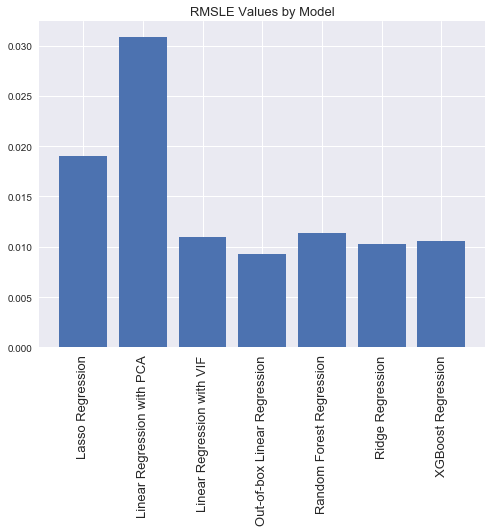

In [104]:
sns.set()
plt.figure(figsize=(8, 6))
plt.title("RMSLE Values by Model", fontsize=13)
plt.bar(regressors, rmsles)
plt.xticks(rotation=90, fontsize=13)
plt.show()

Submissions to Kaggle were consistent with these results, with linear regression resulting in the best score, and the other models performing just slightly worse. The best scoring model on Kaggle resulted in an RMSLE of 0.145, which is in the top half of submissions at the time of submittal.